# Задание

    Постройте регресионную модель для предсказания стоимость машин. 
    От какие факторов зависит ценообразование на автомобили? 
    Оцените качество построенной модели. 

In [155]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

%matplotlib inline

In [272]:
df = pd.read_csv('cars.csv')

In [6]:
df.head(2)

car_ID  symboling              CarName fueltype aspiration doornumber  \
0       1          3   alfa-romero giulia      gas        std        two   
1       2          3  alfa-romero stelvio      gas        std        two   

       carbody drivewheel enginelocation  wheelbase  ...  enginesize  \
0  convertible        rwd          front       88.6  ...         130   
1  convertible        rwd          front       88.6  ...         130   

   fuelsystem  boreratio  stroke compressionratio horsepower  peakrpm citympg  \
0        mpfi       3.47    2.68              9.0        111     5000      21   
1        mpfi       3.47    2.68              9.0        111     5000      21   

   highwaympg    price  
0          27  13495.0  
1          27  16500.0  

[2 rows x 26 columns]

In [6]:
df.shape

(205, 26)

In [8]:
df.isna().sum()

car_ID              0
symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64

In [83]:
# Посмотрим на модели машин
print(df.CarName.nunique())
print('------------------')
print(df.CarName.unique())
# Их очень много и все разные

147
------------------
['alfa-romero giulia' 'alfa-romero stelvio' 'alfa-romero Quadrifoglio'
 'audi 100 ls' 'audi 100ls' 'audi fox' 'audi 5000' 'audi 4000'
 'audi 5000s (diesel)' 'bmw 320i' 'bmw x1' 'bmw x3' 'bmw z4' 'bmw x4'
 'bmw x5' 'chevrolet impala' 'chevrolet monte carlo' 'chevrolet vega 2300'
 'dodge rampage' 'dodge challenger se' 'dodge d200' 'dodge monaco (sw)'
 'dodge colt hardtop' 'dodge colt (sw)' 'dodge coronet custom'
 'dodge dart custom' 'dodge coronet custom (sw)' 'honda civic'
 'honda civic cvcc' 'honda accord cvcc' 'honda accord lx'
 'honda civic 1500 gl' 'honda accord' 'honda civic 1300' 'honda prelude'
 'honda civic (auto)' 'isuzu MU-X' 'isuzu D-Max ' 'isuzu D-Max V-Cross'
 'jaguar xj' 'jaguar xf' 'jaguar xk' 'maxda rx3' 'maxda glc deluxe'
 'mazda rx2 coupe' 'mazda rx-4' 'mazda glc deluxe' 'mazda 626' 'mazda glc'
 'mazda rx-7 gs' 'mazda glc 4' 'mazda glc custom l' 'mazda glc custom'
 'buick electra 225 custom' 'buick century luxus (sw)' 'buick century'
 'buick skyh

###############################

"Вытащим" марку автомобиля из наименования модели.
    
    'buick electra 225 custom' → 'buick'
    'toyota corolla liftback' → 'toyota'
    
###############################

In [273]:
df['car_brand'] = df.CarName.apply(lambda x: x.split(' ')[0])
df.drop(columns=['CarName', 'car_ID'], inplace=True)

In [85]:
# Посмотрим на получившийся столбец
print(df.car_brand.nunique())
print('------------------')
print(df.car_brand.unique())

28
------------------
['alfa-romero' 'audi' 'bmw' 'chevrolet' 'dodge' 'honda' 'isuzu' 'jaguar'
 'maxda' 'mazda' 'buick' 'mercury' 'mitsubishi' 'Nissan' 'nissan'
 'peugeot' 'plymouth' 'porsche' 'porcshce' 'renault' 'saab' 'subaru'
 'toyota' 'toyouta' 'vokswagen' 'volkswagen' 'vw' 'volvo']


In [274]:
# Так лучше, но если присмотреться - некоторые марки написаны с ошибками
df.car_brand = df.car_brand.str.lower()\
                               .replace({   'maxda'    : 'mazda',
                                            'porcshce' : 'porsche',
                                            'vokswagen': 'volkswagen',
                                            'vw'       : 'volkswagen',
                                            'toyouta'  : 'toyota'})

In [87]:
print(df.car_brand.nunique())
print('------------------')
print(df.car_brand.unique())
# Теперь все ок

22
------------------
['alfa-romero' 'audi' 'bmw' 'chevrolet' 'dodge' 'honda' 'isuzu' 'jaguar'
 'mazda' 'buick' 'mercury' 'mitsubishi' 'nissan' 'peugeot' 'plymouth'
 'porsche' 'renault' 'saab' 'subaru' 'toyota' 'volkswagen' 'volvo']


In [88]:
df.columns

Index(['symboling', 'fueltype', 'aspiration', 'doornumber', 'carbody',
       'drivewheel', 'enginelocation', 'wheelbase', 'carlength', 'carwidth',
       'carheight', 'curbweight', 'enginetype', 'cylindernumber', 'enginesize',
       'fuelsystem', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg', 'price', 'car_brand'],
      dtype='object')

###############################

Информации об автомобилях слишком много

Уберем "лишние" для упрощения модели, например:
    
    doornumber очевидно коррелирует с carbody
    enginelocation практически везде front (только в 3 случаях он rear), неинформативно
    cylindernumber в подавляющем большинстве случаев four, также неинформативный предиктор
    И т.д.
    
###############################

In [275]:
df.drop(columns=['symboling',
                 'doornumber',
                 'enginelocation',
                 'carheight',
                 'cylindernumber',
                 'fuelsystem',
                 'boreratio',
                 'stroke',
                 'compressionratio',
                 'peakrpm',
                 'citympg',
                 'highwaympg'], inplace=True)

In [90]:
df.head(2)

fueltype aspiration      carbody drivewheel  wheelbase  carlength  carwidth  \
0      gas        std  convertible        rwd       88.6      168.8      64.1   
1      gas        std  convertible        rwd       88.6      168.8      64.1   

   curbweight enginetype  enginesize  horsepower    price    car_brand  
0        2548       dohc         130         111  13495.0  alfa-romero  
1        2548       dohc         130         111  16500.0  alfa-romero

<AxesSubplot:>

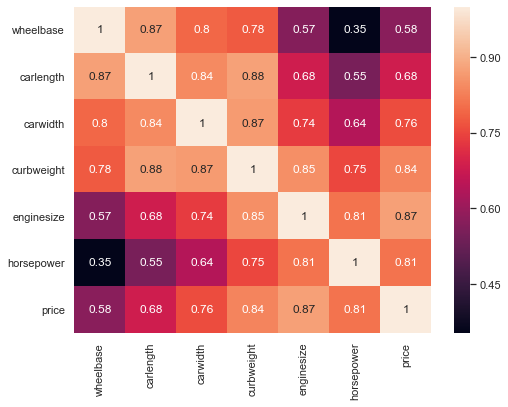

In [255]:
# Построим матрицу корелляций
sns.set(rc={'figure.figsize': (8, 6)})
sns.heatmap(df.corr(), annot=True)

In [93]:
# Посмотрим признаки, наибольшим образом влияющие на price:
df.corr().price.sort_values(ascending=False).round(3)

# Лидируют:
#     - объем двигателя
#     - максимальная снаряженная масса
#     - мощность двигателя
# В принципе, вполне ожидаемо

price         1.000
enginesize    0.874
curbweight    0.835
horsepower    0.808
carwidth      0.759
carlength     0.683
wheelbase     0.578
Name: price, dtype: float64

In [94]:
# Взглянем на типы переменных
df.dtypes.sort_values()

curbweight      int64
enginesize      int64
horsepower      int64
wheelbase     float64
carlength     float64
carwidth      float64
price         float64
fueltype       object
aspiration     object
carbody        object
drivewheel     object
enginetype     object
car_brand      object
dtype: object

In [ ]:
# Тут много категориальных переменных, которые затрудняют использование линейной регрессии
# Преобразуем значения этих переменных в столбцы, в которых будут только значения 1 (True) или 0 (False)

In [256]:
df_dummies = pd.get_dummies(data=df[['fueltype', 
                                     'aspiration', 
                                     'carbody',
                                     'drivewheel', 
                                     'enginetype', 
                                     'car_brand']], drop_first = False)

In [257]:
df.drop(columns=['fueltype', 
                 'aspiration', 
                 'carbody',
                 'drivewheel', 
                 'enginetype', 
                 'car_brand'], inplace=True)

In [258]:
df = pd.concat([df, df_dummies], axis=1)

In [110]:
df.head(2)

wheelbase  carlength  carwidth  curbweight  enginesize  horsepower  \
0       88.6      168.8      64.1        2548         130         111   
1       88.6      168.8      64.1        2548         130         111   

     price  fueltype_diesel  fueltype_gas  aspiration_std  ...  \
0  13495.0                0             1               1  ...   
1  16500.0                0             1               1  ...   

   car_brand_nissan  car_brand_peugeot  car_brand_plymouth  car_brand_porsche  \
0                 0                  0                   0                  0   
1                 0                  0                   0                  0   

   car_brand_renault  car_brand_saab  car_brand_subaru  car_brand_toyota  \
0                  0               0                 0                 0   
1                  0               0                 0                 0   

   car_brand_volkswagen  car_brand_volvo  
0                     0                0  
1                     0                0  

[2 rows x 89 columns]

# Строим модели

### 1 price ~ horsepower

    Сначала построим и оценим простую модель с одним предиктором – мощностью двигателя

<AxesSubplot:xlabel='price', ylabel='horsepower'>

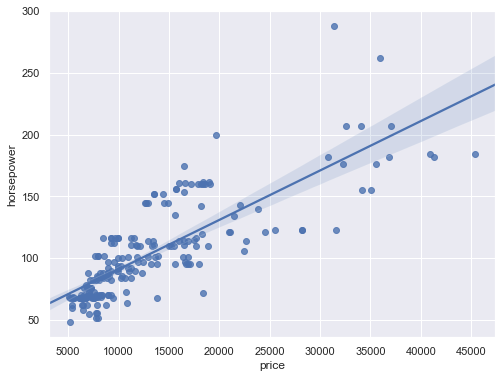

In [111]:
sns.regplot(df.price, df.horsepower)

In [126]:
res = stats.linregress(df.horsepower, df.price)
print(f'slope:     {res[0]}')
print(f'intercept: {res[1]}')
print(f'p-value:   {res[3]}')
print(f'stderr:    {res[4]}')

# Однозначная положительная взаимосвязь цены и мощности автомобиля

slope:     163.26306096964794
intercept: -3721.76149432276
p-value:   1.4834365732938525e-48
stderr:    8.351478808257394


In [156]:
# Построим саму модель и найдем какой процент изменчивости описывает данная модель

X = df.horsepower
X = sm.add_constant(X)
Y = df.price

model_1 = sm.OLS(Y, X) 
results = model_1.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     382.2
Date:                Thu, 25 Feb 2021   Prob (F-statistic):           1.48e-48
Time:                        13:27:36   Log-Likelihood:                -2024.0
No. Observations:                 205   AIC:                             4052.
Df Residuals:                     203   BIC:                             4059.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3721.7615    929.849     -4.003      0.0

In [ ]:
# Коэффициент R-квадрат составляет 65%
# Т.е. изменчивость мощности двигателя описывает 65% изменчивости цены

### 2 price ~ all_predictors

    Построим и оценим модель со всеми одним предикторами

In [263]:
X = sm.add_constant(df.drop(columns=['price']))
model_2 = sm.OLS(df.price, X)
results_2 = model_2.fit()
print(results_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     79.85
Date:                Thu, 25 Feb 2021   Prob (F-statistic):           1.62e-88
Time:                        14:36:38   Log-Likelihood:                -1820.0
No. Observations:                 205   AIC:                             3724.
Df Residuals:                     163   BIC:                             3864.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.805e+

In [149]:
# Коэффициент R-квадрат составляет 94%
# НО если внимательно рассмотреть p-values можем видеть, что много car_brand статистически не значимы:
#     10 car_brand из 22 не являются значимыми

# Попробуем построить модель без них

### 2 price ~ all_predictors_without_car_brand

    Построим и оценим модель со всеми одним предикторами, кроме марок автомобилей

In [264]:
df_without_brand = df.drop(columns=df.columns[df.columns.str.startswith('car_brand')])

X = df_without_brand.drop(columns=['price'])
X = sm.add_constant(X)
Y = df_without_brand['price']

model_3 = sm.OLS(Y, X) 
results_3 = model_3.fit()
print(results_3.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     63.90
Date:                Thu, 25 Feb 2021   Prob (F-statistic):           9.73e-72
Time:                        14:37:15   Log-Likelihood:                -1920.0
No. Observations:                 205   AIC:                             3882.
Df Residuals:                     184   BIC:                             3952.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -2.054e+04   4

In [ ]:
# Данная модель описывает изменчивость стоимости на 86%, но при этом количество предикторов значительно уменьшилось

# Итог:

  - Для прогнозирования стоимости лучше использовать последнюю модель без car_brand, т.к. небольшое снижение коэффициента R-квадрат позволяет значительно уменьшить количество незначимых предикторов
    
  - Выбранная модель объясняет примерно 86% изменчивости стоимости автомобилей
  - Наибольшим образом на стоимость влияют:
      - объем двигателя
      - максимальная снаряженная масса
      - мощность двигателя
      - далее - габариты автомобиля (ширина, длина)

##############################################################################################

### Попробуем спрогнозировать стоимость авто

    Чтобы не писать вручную параметры автомобиля, напишем небольшой код, который добавляет запись в исходный df и через get_dummies выводит список с нужными параметрами-заглушками

In [390]:
# Список параметров автомобиля, для которого нужно спрогнозировать стоимость - в переменной car
temp = pd.read_csv('cars.csv')
temp.drop(columns=['CarName', 
                   'car_ID',
                   'symboling',
                   'doornumber',
                   'enginelocation',
                   'carheight',
                   'cylindernumber',
                   'fuelsystem',
                   'boreratio',
                   'stroke',
                   'compressionratio',
                   'peakrpm',
                   'citympg',
                   'highwaympg'], inplace=True)
temp.loc[temp.index.max() + 1] = ['gas', 'turbo', 'hatchback', 'fwd', 110, 200, 70, 1500, 'dohc', 130, 100, 0]
temp_dummies = pd.get_dummies(data=temp[['fueltype', 'aspiration', 'carbody', 'drivewheel', 'enginetype']])
temp_df = temp.drop(columns=['fueltype', 
                             'aspiration', 
                             'carbody',
                             'drivewheel', 
                             'enginetype'])
temp_df = pd.concat([temp_df, temp_dummies], axis=1)
car = temp_df.loc[205].to_list()

Параметры автомобиля:
fueltype            gas
aspiration        turbo
carbody       hatchback
drivewheel          fwd
wheelbase         110.0
carlength         200.0
carwidth           70.0
curbweight         1500
enginetype         dohc
enginesize          130
horsepower          100
price               0.0
Name: 205, dtype: object
----------------
Наиболее вероятная средняя стоимость автомобия составит: 475823.0
----------------
count       205.0
mean     475823.0
std       75769.0
min      317660.0
25%      418590.0
50%      458654.0
75%      530637.0
max      695464.0
dtype: float64


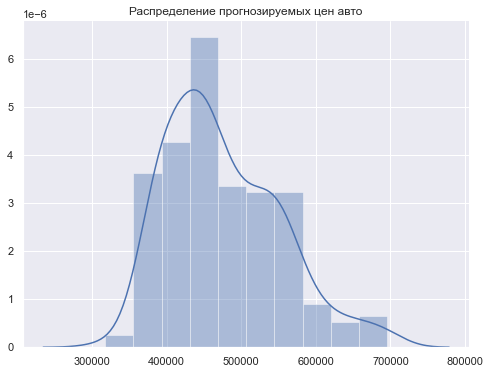

In [391]:
# Получаем распределение вероятных стоимостей автомобиля
prices = pd.Series(model_3.predict(car).tolist())

print('Параметры автомобиля:')
print(f'{temp.loc[temp.index.max()]}\n----------------')
print(f'Наиболее вероятная средняя стоимость автомобия составит: {np.round(prices.mean())}')
print(f'----------------\n{prices.describe().round()}')
sns.distplot(prices).set_title('Распределение прогнозируемых цен авто')
sns.despine()